Импорт нужных библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM #LongShortTermMemory

Загрузка данных

In [2]:
company = 'AAPL'

start = dt.datetime(2012, 1, 1) #1 января 
end = dt.datetime(2021, 1, 1)

data = web.DataReader(company, 'yahoo', start, end)

Подготовка данных

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaler_data)):
    x_train.append(scaler_data[x-prediction_days:x, 0])
    y_train.append(scaler_data[x, 0])

x_train, y_train = np.asarray(x_train), np.asarray(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Построение модели

In [4]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
69/69 [==============================] - 5s 79ms/step - loss: 0.0074
Epoch 2/25
69/69 [==============================] - 5s 77ms/step - loss: 0.0015
Epoch 3/25
69/69 [==============================] - 5s 75ms/step - loss: 0.0014
Epoch 4/25
69/69 [==============================] - 5s 74ms/step - loss: 0.0012
Epoch 5/25
69/69 [==============================] - 5s 69ms/step - loss: 0.0010
Epoch 6/25
69/69 [==============================] - 5s 70ms/step - loss: 0.0011
Epoch 7/25
69/69 [==============================] - 6s 80ms/step - loss: 0.0010
Epoch 8/25
69/69 [==============================] - 5s 70ms/step - loss: 9.6450e-04
Epoch 9/25
69/69 [==============================] - 5s 77ms/step - loss: 0.0011
Epoch 10/25
69/69 [==============================] - 5s 75ms/step - loss: 9.9050e-04: 0s - loss: 9.9050e-0
Epoch 11/25
69/69 [==============================] - 5s 76ms/step - loss: 9.0947e-04
Epoch 12/25
69/69 [==============================] - 5s 76ms/step - loss: 9.4783e-04

Проверяем точность модели на существующих данных

Загружаем тестовые данные

In [5]:
test_start = dt.datetime(2018, 1, 1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

Сделаем предсказания на основе тестовых данных

In [6]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])
    
x_test = np.asarray(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
                    
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

Построим графики тестовых предсказаний

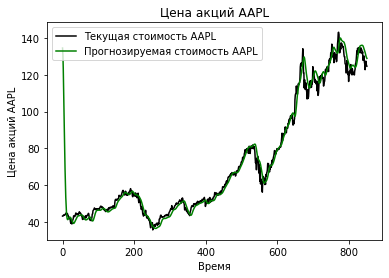

In [7]:
plt.plot(actual_prices, color = "black", label=f"Текущая стоимость {company}")
plt.plot(predicted_prices, color = "green", label=f"Прогнозируемая стоимость {company}")
plt.title(f"Цена акций {company}")
plt.xlabel('Время')
plt.ylabel(f'Цена акций {company}')
plt.legend()
plt.show()

Предсказание завтрашнего дня

In [8]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.asarray(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Предсказание: {prediction}")

Предсказание: [[128.56258]]
